# Project Objective:

In today's digital age, there is a pressing need for an efficient solution that provides the blind, researchers, and the general public with a streamlined and fully automated document digitalization experience. The challenge lies in creating a mobile tool that can swiftly capture high-quality scans in bulk, detect page flips, correct and enhance image quality, and recognize text with formatting integrity.

The goal of this project is to build model which, given a series of images, can detect whether a page in a document is being flipped using a single image. The F1 score will be used as our measure of success. The aim is to attain a score closest to the value of 1, indicating near perfect precision and recall.

# Importing Necessary Libraries

In [ ]:
import os
from tqdm import tqdm
import cv2
from random import shuffle
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
import zipfile
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.metrics import AUC, F1Score, Precision, Recall
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split





# About The Data
The data provided is a collection of videos recording a page flip from smart phones. Videos were  labeled as flipped or not flipped when action of either occurred in the eye of the observer. The extracted frames were then saved to disk in sequential order


# Extracting Directories From Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/image_data_apziva_project'

In [ ]:
X = []
Z = []

flip = '/content/drive/MyDrive/image_data_apziva_project/images/training/flip'
notflip = '/content/drive/MyDrive/image_data_apziva_project/images/training/notflip'



# Image Loading and Extraction

the function is below is used to tag each image based its respective postion(flipped or not flipped)

In [ ]:
def assign_label(image, position):
    return position




Creating a function called "create_train_data" to load, read and resize each image into a list called "X". Each image is also tagged/labeled respectively and appended into a list called "Z".

In [ ]:
def create_train_data(position, dir):
    for img in tqdm(os.listdir(dir)):
        label = assign_label(img, position)
        path = os.path.join(dir, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (150, 150))

        X.append(np.array(img))
        Z.append(str(label))


In [ ]:
create_train_data('flipped', flip)
create_train_data('not flipped', notflip)


100%|██████████| 1230/1230 [00:38<00:00, 31.97it/s]


In [ ]:
len(X)


2392

# Viewing Random Images of The Training Set

A plot of random images from the created training set is done below to better understand the data that I was working with.

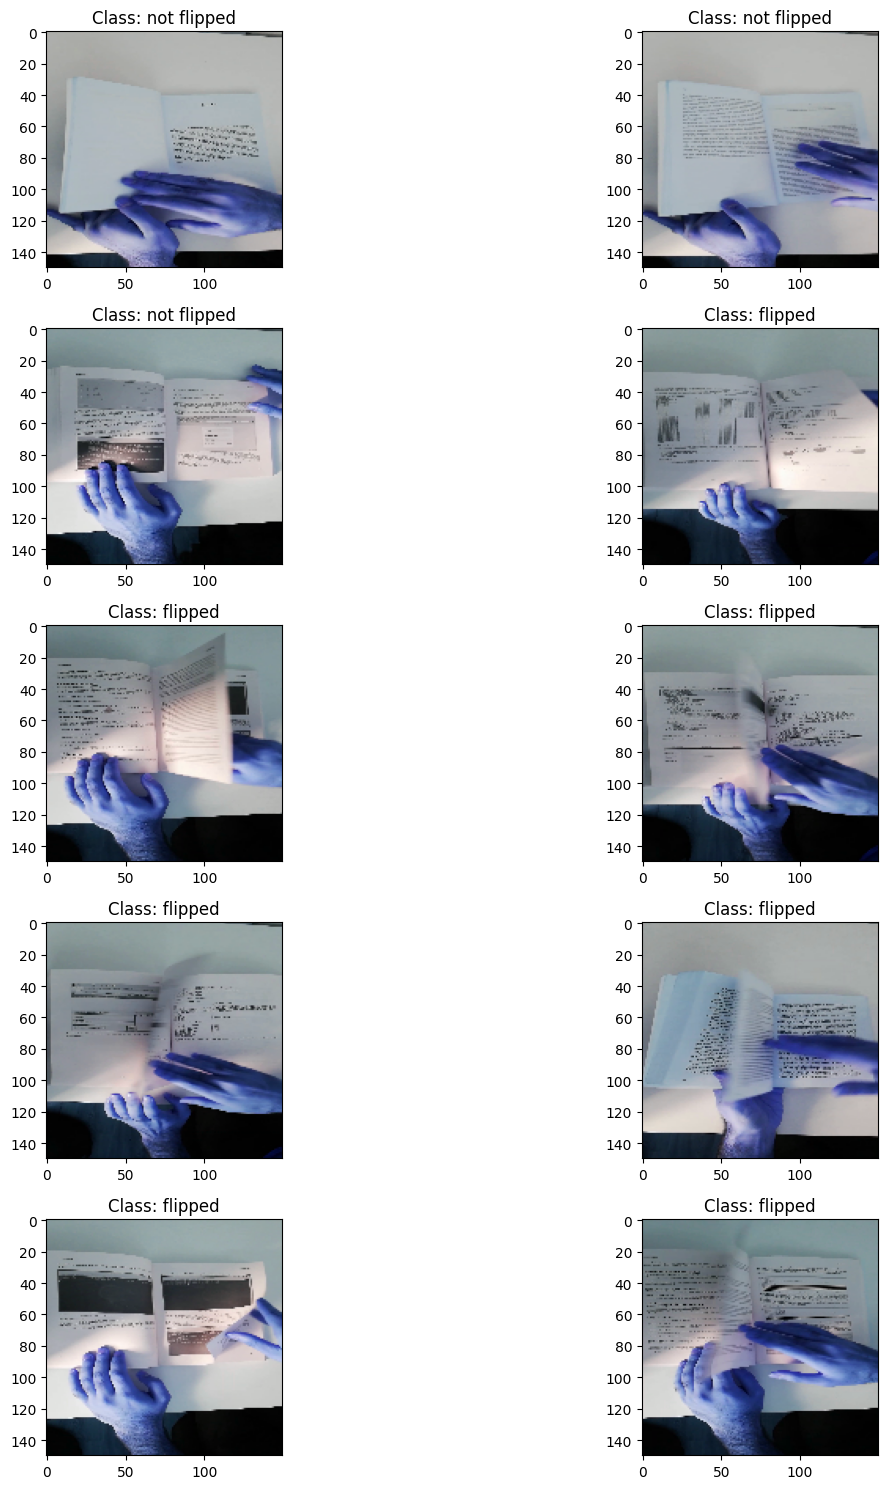

In [ ]:
import random
fig, ax = plt.subplots(5,2)
fig.set_size_inches(15, 15)
for i in range(5):
  for j in range(2):
    l = random.randint(0, len(X))
    ax[i,j].imshow(X[l])
    ax[i,j].set_title('Class: ' + Z[l])
plt.tight_layout()




# Preprocessing Images And Labels

In [ ]:
X = np.array(X)
Y = np.array(Z)



In [ ]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = np.array(Y)






In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1234)


In [ ]:
y_train.shape



(1794,)

In [ ]:
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


In [ ]:
X_train = X_train/255.0
X_test = X_test/255.0



In [ ]:
import tensorflow as tf



# Model Building

In [ ]:
np.random.seed(1234)

random.seed(1234)

tf.random.set_seed(1234)
batch_size = 16
epochs = 50
steps_per_epoch = len(X_train) // batch_size


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))






In [ ]:
from keras.metrics import F1Score



# Learning Rate Annealer

In [ ]:
from keras.callbacks import ReduceLROnPlateau
rlrop = ReduceLROnPlateau(monitor='val_f1_score', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)



# Image Augmentation



In [ ]:
image_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
#image_gen.fit(X_train)



In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[F1Score(threshold=0.5)])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 11, 11, 128)       0

In [ ]:
for x_batch, y_batch in image_gen.flow(X_train, y_train, batch_size=batch_size):
    print(x_batch.shape, y_batch.shape)
    break


(16, 150, 150, 3) (16,)


In [ ]:
results = model.fit(X_train, y_train, batch_size=batch_size,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=(X_test, y_test))







Epoch 1/50
112/112 [==============================] - 7s 20ms/step - loss: 0.6863 - f1_score: 0.6292 - val_loss: 0.6160 - val_f1_score: 0.6644
Epoch 2/50
112/112 [==============================] - 1s 12ms/step - loss: 0.4745 - f1_score: 0.7952 - val_loss: 0.2931 - val_f1_score: 0.8926
Epoch 3/50
112/112 [==============================] - 1s 12ms/step - loss: 0.2893 - f1_score: 0.8867 - val_loss: 0.3067 - val_f1_score: 0.8789
Epoch 4/50
112/112 [==============================] - 1s 12ms/step - loss: 0.1690 - f1_score: 0.9348 - val_loss: 0.1431 - val_f1_score: 0.9419
Epoch 5/50
112/112 [==============================] - 1s 12ms/step - loss: 0.1011 - f1_score: 0.9643 - val_loss: 0.0621 - val_f1_score: 0.9833
Epoch 6/50
112/112 [==============================] - 1s 12ms/step - loss: 0.0868 - f1_score: 0.9657 - val_loss: 0.0832 - val_f1_score: 0.9748
Epoch 7/50
112/112 [==============================] - 1s 12ms/step - loss: 0.0604 - f1_score: 0.9826 - val_loss: 0.0424 - val_f1_score: 0.9817

# Validation

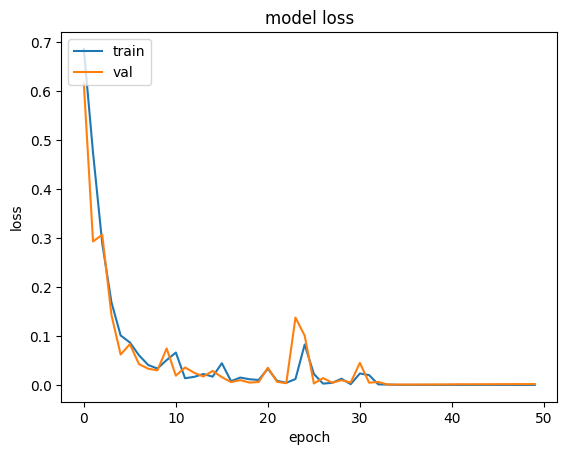

In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

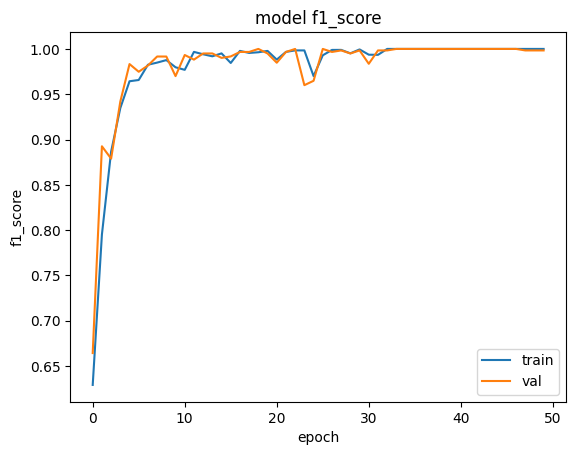

In [ ]:
plt.plot(results.history['f1_score'])
plt.plot(results.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# Creating The Test Set From The Test Directory

In [ ]:
test_flipped = '/content/drive/MyDrive/image_data_apziva_project/images/testing/flip'
test_notflipped = '/content/drive/MyDrive/image_data_apziva_project/images/testing/notflip'


In [ ]:
test = []
test_label = []

In [ ]:
def create_test_data(position, dir):
    for img in tqdm(os.listdir(dir)):
        label = assign_label(img, position)
        path = os.path.join(dir, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (150, 150))

        test.append(np.array(img))
        test_label.append(str(label))

In [ ]:
create_test_data('flipped', test_flipped)
create_test_data('not flipped', test_notflipped)


100%|██████████| 307/307 [00:08<00:00, 36.95it/s]


In [ ]:
ec = LabelEncoder()
test_label = ec.fit_transform(test_label)



In [ ]:
test = np.array(test)
test_data = np.array(test)/255.0


test_label = np.array(test_label).astype('float32')



In [ ]:
test = test.astype('float32')



# Model Evaluation
The model managed to achieve an f1 score of 0.9745

In [ ]:
model.evaluate(test, test_label, batch_size=batch_size)






38/38 [==============================] - 0s 9ms/step - loss: 24.0357 - f1_score: 0.9745


[24.03571891784668, array([0.97452235], dtype=float32)]

# Conclusion
My motivation behind using image augmentation was that convolutional nueral networks require a massive amount of training data before it can generalise well. However, after several attempts at making minor alterations to create more training data, my model's performance got worse after each epoch, to a point that the f1 score did not improve at all. With image augmentation, I achieved an f1 score of 0.6825. Without it, I attained an f1 score 0.9745. After several attempts, I decided to build a simple CNN model, which turned out to perfrom significantly better. To my surprise, the model even did well when I evaluated it on the test set.

I had some concerns about overfitting, which was why I tried to use a learning rate annealer to adjust the learning rate after each epoch. This approach was also not succesful.